In [1]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count, lit
from pyspark.sql.types import DoubleType, StringType
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime 
print(datetime.datetime.now())
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

2019-08-29 20:28:26.888067


## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [2]:
df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)

In [3]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

In [4]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [5]:
df1 = df1.withColumn('exemptland', lit(None).cast(StringType()))

In [6]:
cols = df2.columns

In [7]:
df1 = df1.select(cols)
df2 = df2.select(cols)

## Type Conversion

In [8]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [9]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()
condo_null_1 = df1.filter(df1['lot'].rlike(r'^75'))\
                    .select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [10]:
null_1

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,0,1,1,3124,3611,3124,3842,3125,25347,3862,...,826394,795384,7,0,0,0,0,861089,861096,7


In [11]:
condo_null_1

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,0,0,0,78,85,78,90,78,272,90,...,11834,11379,0,0,0,0,0,12490,12490,0


In [12]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()
condo_null_2 = df2.filter(df2['lot'].rlike(r'^75'))\
                    .select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [13]:
null_all = pd.concat([null_2, null_1])
condo_null_all = pd.concat([condo_null_2, condo_null_1])

null_change = null_all.pct_change()
condo_null_change = condo_null_all.pct_change()

In [14]:
null_change.iloc[1,:].sort_values(ascending=False)[0:10]

sanitsub     4.751381
ownername    4.127796
lotfront     3.440539
taxmap       3.272099
tract2010    2.618000
ct2010       2.611000
council      2.125000
cd           2.124000
cb2010       2.124000
sanborn      2.096903
Name: 0, dtype: float64

In [15]:
condo_null_change.iloc[1,:].sort_values(ascending=False)[0:10]

lotfront     9.616264
sanitsub     5.733333
tract2010    4.312500
ct2010       4.312500
taxmap       4.200000
cd           3.875000
sanborn      3.875000
council      3.875000
cb2010       3.875000
lotdepth     3.435775
Name: 0, dtype: float64

In [16]:
null_all.index = ['18v2.1', '19v1']
null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
18v2.1,0,8,8,1000,1000,1000,1638,1000,20541,1673,...,824299,793294,6,6,6,6,6,858982,858982,6
19v1,0,1,1,3124,3611,3124,3842,3125,25347,3862,...,826394,795384,7,0,0,0,0,861089,861096,7


In [17]:
condo_null_all.index = ['18v2.1', '19v1']
condo_null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
18v2.1,0,0,0,16,16,16,27,16,174,27,...,11697,11247,0,0,0,0,0,12346,12346,0
19v1,0,0,0,78,85,78,90,78,272,90,...,11834,11379,0,0,0,0,0,12490,12490,0


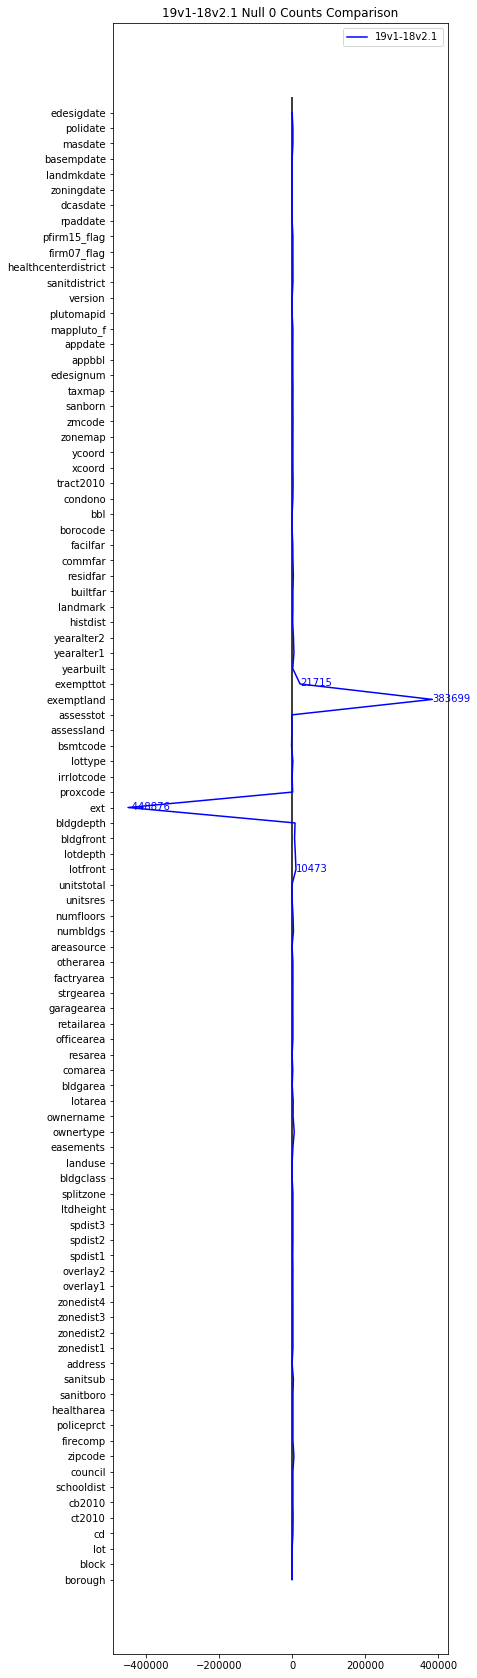

In [18]:
plt.figure(figsize=(6, 30))

difference1 = null_all.iloc[1, :]-null_all.iloc[0, :]

plt.plot(difference1, range(96), label = '19v1-18v2.1', color = 'blue')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(difference1[i]) >= 10000:
        plt.text(x = difference1[i] , y = i - 0.15, s = '{}'.format(difference1[i]), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1-18v2.1 Null 0 Counts Comparison')
plt.legend()
plt.show()

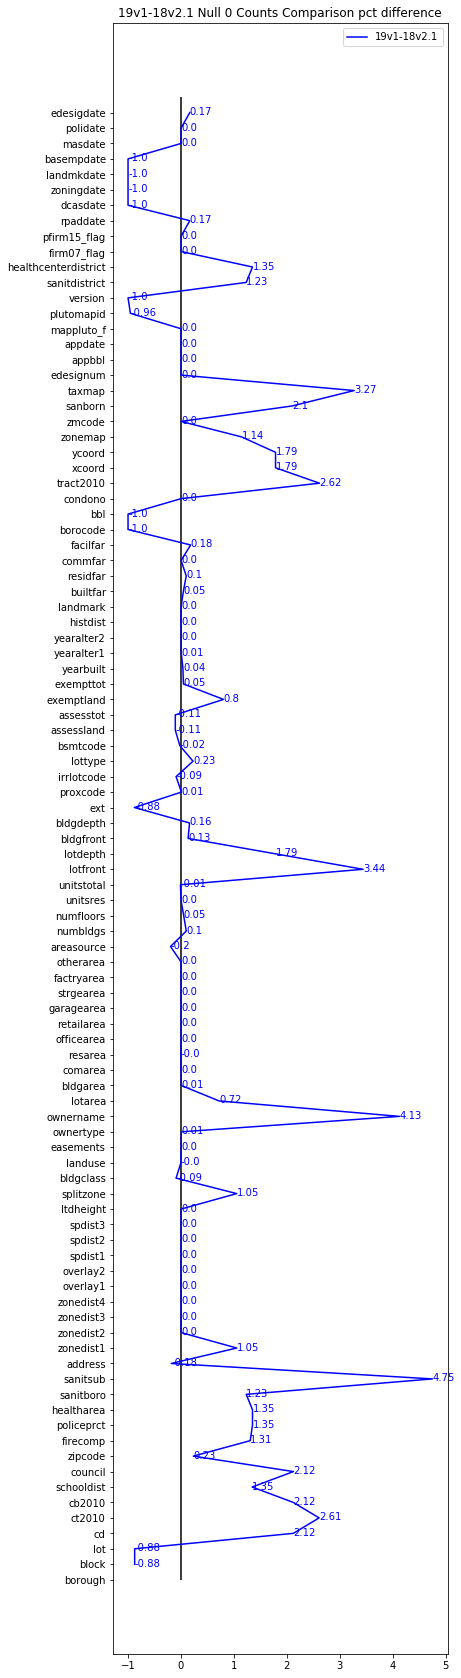

In [19]:
plt.figure(figsize=(6, 30))

plt.plot(null_change.iloc[1,:], range(96), label = '19v1-18v2.1', color = 'blue')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(null_change.iloc[1,i]) <= 100:
        plt.text(x = null_change.iloc[1,i] , y = i - 0.15, s = '{}'.format(np.round(null_change.iloc[1,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1-18v2.1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('19v1-18v2.1-Null0-Comparison-pct.png', bbox_inches='tight')
plt.show()

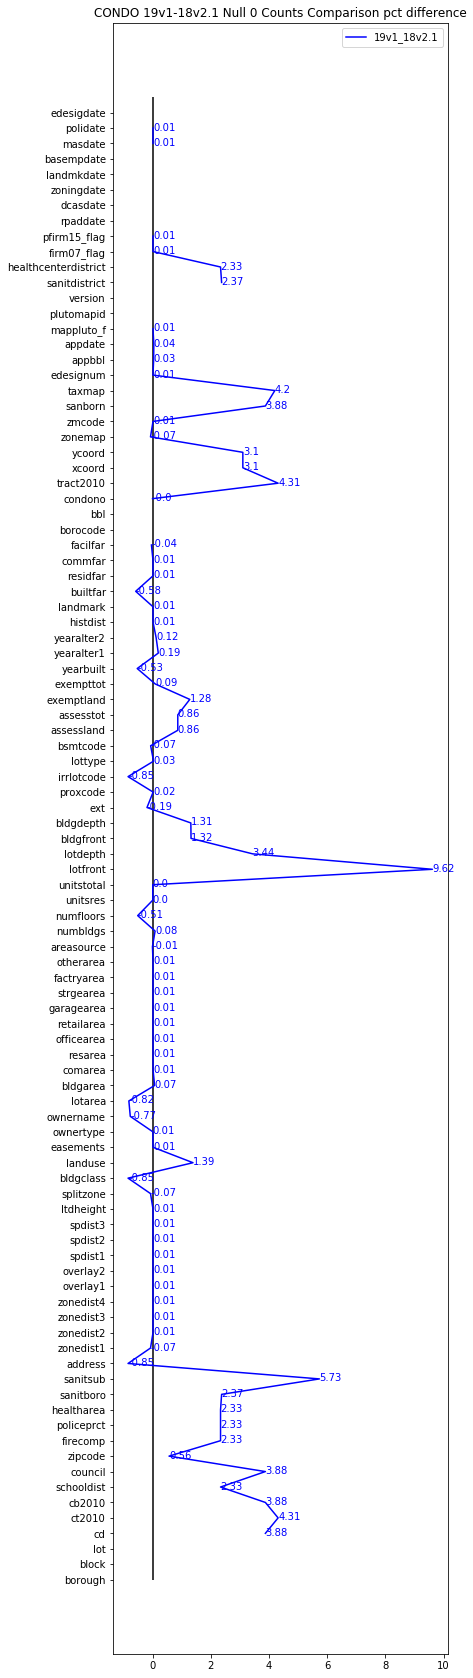

In [20]:
plt.figure(figsize=(6, 30))

plt.plot(condo_null_change.iloc[1,:], range(96), label = '19v1_18v2.1', color = 'blue')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(condo_null_change.iloc[1,i]) <= 100:
        plt.text(x = condo_null_change.iloc[1,i] , y = i - 0.15, s = '{}'.format(np.round(condo_null_change.iloc[1,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), condo_null_change.columns, rotation='horizontal')
plt.title('CONDO 19v1-18v2.1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('CONDO 19v1-18v2.1-Null0-Comparison-pct.png', bbox_inches='tight')
plt.show()

In [21]:
import os

os.system('jupyter nbconvert --to pdf pluto19v1-18v2.1-null_comparison.ipynb')

0